# Projet TER

In [1]:
from __future__ import print_function
# %matplotlib inline
import argparse
import os
import os.path as osp
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from tqdm import tqdm
from torch import Tensor
import pickle
from datetime import datetime

import copy # To make a copy of a model


from torchvision import datasets, transforms
from torch.utils.data import random_split
from torchsummary import summary


import utils

import utils
from utils.dataset import *
from utils.model import *
from utils.model import UNet_modular
from utils.utils import *


import csv


# Set random seed for reproducibility
manualSeed = 999
# manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


"""
# If there are issues with the kernel, try the following :


python3 -m pip install ipykernel
python3 -m ipykernel install --user

python3 -m pip install ipykernel -U --user --force-reinstall

python3.6 -m pip install torchvision
"""

/home/mehtali/env/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Random Seed:  999


'\n# If there are issues with the kernel, try the following :\n\n\npython3 -m pip install ipykernel\npython3 -m ipykernel install --user\n\npython3 -m pip install ipykernel -U --user --force-reinstall\n\npython3.6 -m pip install torchvision\n'

In [2]:
def load_model(model, path=""):
	if len(path)>0:
		state_dict = torch.load(path)
		model.load_state_dict(state_dict)
	model.to(device=device)

	if (device.type == 'cuda') and (ngpu > 1):
		print("Data Parallel")
		model = nn.DataParallel(model, list(range(ngpu)))
	
	return model


def load_student_model(path=""):
	# STUDENT
	return load_model(UNet_modular(channel_depth = 16, n_channels = 3, n_classes=3), path)


def load_teacher_model(path=""):
	# TEACHER
	return load_model(UNet_modular(channel_depth = 32, n_channels = 3, n_classes=3), path)

# Other

def save_model(model, path):
	torch.save(model.state_dict(), path)

# Function that returns a list of paths in a folder that start with a word and that are sorted in increasing order
def get_path_list(path, start_with=""):
	path_list = []
	for file in os.listdir(path):
		if file.startswith(start_with):
			path_list.append(os.path.join(path, file))
	path_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
	return path_list
# Function that returns in a path list with the first number in the name

def get_trainable_param(model):
	model_parameters = filter(lambda p: p.requires_grad, model.parameters())
	return sum([np.prod(p.size()) for p in model_parameters])


def show_prediction(model, val_loader, n=0):
	model.eval().cuda()

	with torch.no_grad():
		for i,(img,gt) in enumerate(val_loader):
			if n !=0 and i > n:
				break
		
			if torch.cuda.is_available():
				img, gt = img.cuda(), gt.cuda()
			img, gt = Variable(img), Variable(gt)

			output = model(img)
			output = output.clamp(min = 0, max = 1)
			gt = gt.clamp(min = 0, max = 1)
			



			# Plot image, output and ground truth one one row
			fig, ax = plt.subplots(1,3, figsize=(15,15))
			ax[0].imshow(img[0].cpu().numpy().transpose(1,2,0))
			ax[1].imshow(output[0].cpu().numpy().transpose(1,2,0))
			ax[2].imshow(gt[0].cpu().numpy().transpose(1,2,0))
			# Name each axis
			ax[0].set_title("Image")
			ax[1].set_title("Output")
			ax[2].set_title("Ground Truth")
			
			plt.show()
	

In [3]:
date = str(datetime.now()).split(' ')[0]
heure = str(datetime.now()).split(' ')[1].split('.')[0]

# Root directory for dataset
# Refaire nos data folder et tout pour que ce soit
# au format demandé par le dataloader

# Leave empty if you want to use the default name or load a previous session
session_name = "IGBMC_I3_DISTILLATION_V3"

if len(session_name) == 0:
	session_name = "IGBMC_I3"+"_"+str(date)+"_"+str(heure)


dataset_folder = "/home/mehtali/TER_CNN_Compression/Data/training-data/data/IGBMC_I3_diversifie/patches/"
train_list = dataset_folder+"train_4000_i3.txt"
teacher_train_list = dataset_folder+"train_10000_i3.txt"
test_list = dataset_folder+"test_5000-7500_i3.txt"
validate_list = dataset_folder+"test_1000.txt"


# Number of workers for dataloader
workers = 10

# Batch size during training (low batch_size if there are memory issues)
batch_size = 10

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size_source = 256
image_size_target = 256
image_size_discriminator = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
learning_rate = 1e-5  # e-5

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Saves every batch_save_interval
batch_save_interval = 2

# some net variable
amp = False

save_path =  "../Data/Saves/" + session_name+"/"
model_path = save_path+"newtork_weigths/"
log_path = save_path+"logs/"
fig_path = save_path+"fig/"


if not os.path.exists("../Data"):
	os.mkdir("../Data")
if not os.path.exists("../Data/Saves" ):
	os.mkdir("../Data/Saves" )

# We create this folder (only if it doesn't exists) to save weights of the training at some keys epoch
if not os.path.exists(save_path):
	os.mkdir(save_path)
	os.mkdir(model_path)
	os.mkdir(log_path)
	os.mkdir(fig_path)


log_file = open(log_path+"log.txt", "w")

log_file.write("dataset_folder :"+dataset_folder+"\n")
log_file.write("batch_size="+str(batch_size)+"\n")
log_file.write("learning_rate_net="+str(learning_rate)+"\n")
log_file.write("num_epoch="+str(num_epochs)+"\n")
log_file.write("nc="+str(nc)+"\n")
log_file.close()


In [4]:
print("number of gpus :", torch.cuda.device_count())

# Decide which device we want to run on
device = torch.device("cuda:0" if (
	torch.cuda.is_available() and ngpu > 0) else "cpu")

# On regarde l'identifiant du GPU ou CPU sur lequel on travaille
print("device ID", device)
print("nom du GPU", torch.cuda.get_device_name(device))  # On vérifie son "nom"

torch.cuda.empty_cache()


number of gpus : 4
device ID cuda:0
nom du GPU NVIDIA GeForce RTX 2080 Ti


images source :  torch.Size([10, 3, 256, 256])
mask source : torch.Size([10, 1, 256, 256])


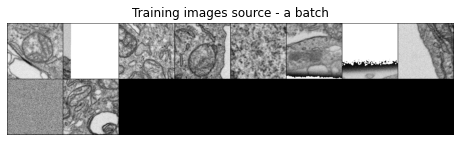

In [5]:
# For data augmentation

geometric_augs = [
	# transforms.Resize((256, 256)), # Makes it easier to process using net
	# transforms.RandomRotation(degrees=(0, 180)),
	transforms.RandomHorizontalFlip(),
	transforms.RandomVerticalFlip(),
	# transforms.RandomRotation(45),
]

color_augs = [
	# transforms.ColorJitter(hue=0.05, saturation=0.4)
]


def make_tfs(augs):
	return transforms.Compose([transforms.ToPILImage()]+augs + [transforms.ToTensor()])


tfs = transforms.Compose(geometric_augs)


# Importation des images et masques de i3
train_dataset = SegmentationDataSet(root=dataset_folder,
							  list_path=train_list,
							  transform_img=make_tfs(
								  geometric_augs + color_augs),
							  transform_label=make_tfs(geometric_augs)
							  )

teacher_train_dataset = SegmentationDataSet(root=dataset_folder,
							  list_path=teacher_train_list,
							  transform_img=make_tfs(
								  geometric_augs + color_augs),
							  transform_label=make_tfs(geometric_augs)
							  )

# Not a good idea to augment the test data
test_dataset = SegmentationDataSet(root=dataset_folder,
								list_path=test_list
								)
# Not a good idea to augment the test data
validate_dataset = SegmentationDataSet(root=dataset_folder,
								list_path=validate_list
								)



train_dataloader = torch.utils.data.DataLoader(train_dataset,
											   batch_size=batch_size,
											   shuffle=True,
											   num_workers=workers)

teacher_train_dataloader= torch.utils.data.DataLoader(teacher_train_dataset,
											   batch_size=batch_size,
											   shuffle=True,
											   num_workers=workers)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
											  batch_size=batch_size,
											  shuffle=True,
											  num_workers=workers)

validation_dataloader = torch.utils.data.DataLoader(validate_dataset,
											  batch_size=batch_size,
											  shuffle=True,
											  num_workers=workers)


batch = next(iter(train_dataloader))

# On affiche quelques exemple du batch pour vérifier qu'on a bien importé les données
print("images source : ", batch[0].shape)
print("mask source :", batch[1].shape)



plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images source - a batch")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(
	device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))


# Neural net architecture

## Load or create neural net

In [6]:
# On revérifie qu'on tourne bien le réseau de neuronnes sur le GPU
print("We are running U-Net on :", torch.cuda.get_device_name(device))

teacher_summary = summary(load_teacher_model(), (3, 256, 256), verbose=0)

student_summary = summary(load_student_model(), (3, 256, 256), verbose=0)


log_file = open(log_path+"model_architectures.txt", "w")

log_file.write("Teacher network summary\n"+str(teacher_summary)+"\n\n")
log_file.write("Student network summary\n"+str(student_summary)+"\n")
log_file.close()

We are running U-Net on : NVIDIA GeForce RTX 2080 Ti


## Training

In [7]:
def evaluate(model, val_loader):
	model.eval().cuda()

	criterion = nn.BCEWithLogitsLoss()
	ll = []
	dl = []
	with torch.no_grad():
		for i,(img,gt) in enumerate(val_loader):
			if torch.cuda.is_available():
				img, gt = img.cuda(), gt.cuda()
			img, gt = Variable(img), Variable(gt)

			output = model(img)
			output = output.clamp(min = 0, max = 1)
			gt = gt.clamp(min = 0, max = 1)
			loss = dice_loss(output, gt)
			dice = dice_coeff(output, gt)
			ll.append(loss.item())
			dl.append(dice.item())

	
	mean_dice = np.mean(dl)
	mean_loss = np.mean(ll)
	print("Eval metrics : dice {:.3f} and loss {:.3f}.".format(mean_dice, mean_loss))
	return mean_dice, mean_loss


def train(model, optimizer, train_loader):
	model.train().cuda()
	criterion = nn.BCEWithLogitsLoss()
	ll = []
	dl = []
	with tqdm(total=len(train_loader)*train_loader.batch_size, desc=f'Training', unit='img') as pbar:
		for i, (img, gt) in enumerate(train_loader):
			#print('i', i)
			if torch.cuda.is_available():
				img, gt = img.cuda(), gt.cuda()
			
			img, gt = Variable(img), Variable(gt)

			output = model(img)
			output = output.clamp(min = 0, max = 1)
			gt = gt.clamp(min = 0, max = 1)
			loss = dice_loss(output, gt)
			dice = dice_coeff(output, gt)
			ll.append(loss.item())
			dl.append(dice.item())

			
			optimizer.zero_grad()
			loss.backward()

			optimizer.step()

			pbar.update(len(img))
			pbar.set_postfix(**{'loss': loss.item(), "dice": dice.item()})
	
	mean_dice = np.mean(dl)
	mean_loss = np.mean(ll)

	print("Average dice {:.3f} and loss {:.3f} over this epoch.".format(mean_dice, mean_loss))

	return mean_dice, mean_loss


# Glbal teacher model
g_teacher_model = load_teacher_model()
T = 1  # temperature for distillation loss
# Using a higher value for T produces a softer probability distribution over classes
alpha = 0.95
# trade-off between soft-target (st) cross-entropy and true-target (tt) cross-entropy;
# loss = alpha * st + (1 - alpha) * tt

# Training function where the teacher model is used to generate soft targets in the case of image segmentation
def train_distilled(model, optimizer, train_loader):
	model.train().cuda()
	criterion = nn.BCEWithLogitsLoss()
	ll = []
	dl = []
	with tqdm(total=len(train_loader)*train_loader.batch_size, desc=f'Training', unit='img') as pbar:
		for i, (img, gt) in enumerate(train_loader):
			#print('i', i)
			if torch.cuda.is_available():
				img, gt = img.cuda(), gt.cuda()
			
			img, gt = Variable(img), Variable(gt)

			output = model(img)
			output = output.clamp(min = 0, max = 1)
			gt = gt.clamp(min = 0, max = 1)
			loss = dice_loss(output, gt)
			dice = dice_coeff(output, gt)
			ll.append(loss.item())
			dl.append(dice.item())

			# Compute soft targets using the teacher model
			with torch.no_grad():
				soft_targets = g_teacher_model(img)
				soft_targets = soft_targets.clamp(min = 0, max = 1)
				soft_targets = F.softmax(soft_targets/T, dim=1)

			# Compute the true targets
			true_targets = gt

			# Compute the distillation loss
			distillation_loss = dice_loss(F.softmax(output/T, dim=1), soft_targets) * (T * T) * alpha + loss * (1. - alpha)

			optimizer.zero_grad()
			distillation_loss.backward()

			optimizer.step()

			pbar.update(len(img))
			pbar.set_postfix(**{'loss': distillation_loss.item(), "dice": dice.item()})

	mean_dice = np.mean(dl)
	mean_loss = np.mean(ll)

	print("Average dice {:.3f} and loss {:.3f} over this epoch.".format(mean_dice, mean_loss))

	return mean_dice, mean_loss



In [8]:
def model_training(model, train_loader, val_loader, trainFun, evalFun, n_epochs, name=""):
	optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
	scheduler = StepLR(optimizer, step_size = 100, gamma = 0.2)

	former_best_dice = 0 # Worst possible
	former_best_loss = 1 # Worst possible
	early_stopping_streak = 0

	scheduled_saves = 0
	best_modem = model

	for epoch in range(n_epochs):
		print(" --- training: epoch {}".format(epoch+1))
		# Train the model
		train_dice, train_loss = trainFun(model, optimizer, train_loader)

		# Modulate training rate
		scheduler.step()

		#evaluate for one epoch on validation set
		valid_dice, valid_loss = evalFun(model, val_loader)
		
		#if val_metric is best, add checkpoint
		if (epoch%10 == 0 or epoch==(n_epochs-1)):
			scheduled_saves+=1
		

		if former_best_dice < valid_dice:
			# dice is increasing
			early_stopping_streak = 0
			best_modem = copy.deepcopy(model)
			if name != "" and scheduled_saves > 0:
				scheduled_saves -= 1
				save_model(model, model_path+name+"_dice_{:.3f}_loss_{:.3f}_epoch_{}.pth".format(valid_dice, valid_loss, epoch+1))
		else:
			# Is decresing
			early_stopping_streak += 1
			if early_stopping_streak >= 20:
				# 15 consecutive epochs without improvement in dice
				print("Early stopping at epoch {}".format(epoch+1))
				break
		
		former_best_dice = max(former_best_dice, valid_dice)
		former_best_loss = min(former_best_loss, valid_loss)
		
	return (best_modem, former_best_dice, former_best_loss)


In [9]:
# Function to test the model usign the evaluate(model, val_loader) function
# on multiple test runs
def evaluate_model(model, n_tests=10):
    dice = []
    loss = []
    for i in range(n_tests):
        print("Test run {}".format(i+1))
        train_dataset = SegmentationDataSet(root=dataset_folder,
							  list_path=train_list,
							  transform_img=make_tfs(
								  geometric_augs + color_augs),
							  transform_label=make_tfs(geometric_augs)
							  )

        train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    num_workers=workers)

        d, l = evaluate(model, train_dataloader)
        dice.append(d)
        loss.append(l)
    return dice, loss
	

In [10]:
n_epochs = 200
n_models = 10

In [11]:
log_file = open(log_path+"model_performance.txt", "w")
log_file.write("Model description\tDice\tLoss\n")
log_file.flush()

# Teacher model
g_teacher_model = load_model(UNet_modular(channel_depth=32, n_channels=3, n_classes=1))
model_descr = "teacher_model_param_{}".format(get_trainable_param(g_teacher_model))
teacher_load_path = "/home/mehtali/TER_CNN_Compression/Data/Saves/IGBMC_I3_DISTILLATION/newtork_weigths/best_teacher_model_param_3352257.pth"
if teacher_load_path != "":
	g_teacher_model.load_state_dict(torch.load(teacher_load_path))
else:
	# Train teacher Model
	g_teacher_model, best_dice, best_loss = model_training(g_teacher_model, teacher_train_dataloader, validation_dataloader, train, evaluate, n_epochs)
	save_model(g_teacher_model, model_path+"best_"+model_descr+".pth")
	log_file.write("{} dice_{:.3f} loss_{:.3f}\n".format(model_descr, best_dice, best_loss))
	log_file.flush()

# Train smaller models
for i in range(3, n_models+1):
	# Distilled model
	model = load_model(UNet_modular(channel_depth=2*i, n_channels=3, n_classes=1))
	model_descr = "distilled_model_{}_param_{}".format(i, get_trainable_param(model))
	nd_model, best_dice, best_loss = model_training(model, train_dataloader, validation_dataloader, train_distilled, evaluate, n_epochs)
	save_model(model, model_path+"best_"+model_descr+".pth")
	log_file.write("{} dice_{:.3f} loss_{:.3f}\n".format(model_descr, best_dice, best_loss))
	log_file.flush()

"""
for i in range(1, n_models+1):
	# Not Distilled model
	model = load_model(UNet_modular(channel_depth=2*i, n_channels=3, n_classes=1))
	model_descr = "not_distilled_model_{}_param_{}".format(i, get_trainable_param(model))
	d_model, best_dice, best_loss = model_training(model, train_dataloader, validation_dataloader, train, evaluate, n_epochs)
	save_model(model, model_path+"best_"+model_descr+".pth")
	log_file.write("{} dice_{:.3f} loss_{:.3f}\n".format(model_descr, best_dice, best_loss))
	log_file.flush()
"""

log_file.close()

 --- training: epoch 1


Training:  45%|████▍     | 1790/4000 [00:10<00:12, 172.71img/s, dice=0.291, loss=0.0224]

# Testing

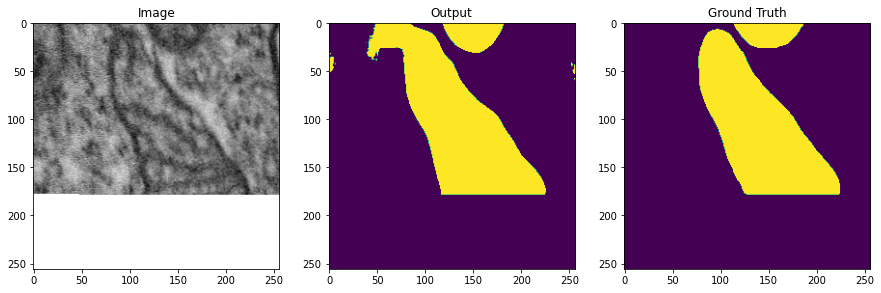

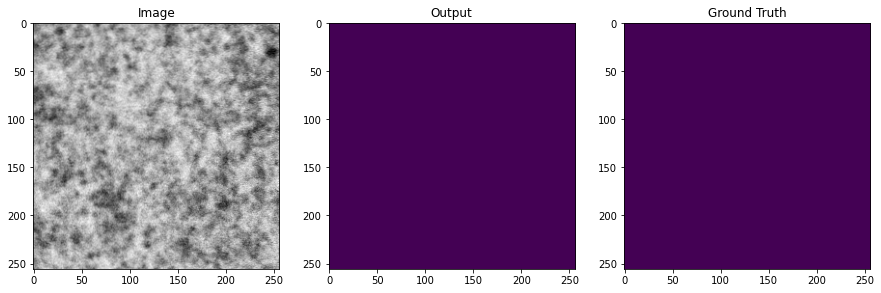

In [ ]:
# Tast a model
model = load_model(
    load_model(UNet_modular(channel_depth=32, n_channels=3, n_classes=1)),
    "/home/mehtali/TER_CNN_Compression/Data/Saves/IGBMC_I3_DISTILLATION_V3/newtork_weigths/best_teacher_model_param_3352257.pth")

show_prediction(model, test_dataloader, 1)

## Load multiple training sets

## Load models for testing

In [ ]:
nd_model_paths = get_path_list(model_path, "best_not_distilled")

d_model_paths = get_path_list(model_path, "best_distilled")

print("Amount of not distilled models: {}".format(len(nd_model_paths)))
print("Amount of distilled models: {}".format(len(d_model_paths)))

# Load the not distilled models in a list, initiating the GenericNetwork model with the correct size
nd_models = []
for i in range(len(nd_model_paths)):
	model = load_model(UNet_modular(channel_depth=2*(1+i), n_channels=3, n_classes=1), nd_model_paths[i])
	nd_models.append(model)



# Load the distilled models in a list, initiating the GenericNetwork model with the correct size
d_models = []
for i in range(len(d_model_paths)):
	model = load_model(UNet_modular(channel_depth=2*(1+i), n_channels=3, n_classes=1), d_model_paths[i])
	d_models.append(model)





Amount of not distilled models: 10
Amount of distilled models: 10


In [ ]:
n_tests = 1

d_loss = []
d_dice = []
d_param = []

print("Testing models with distillation")
for i in range(0, len(d_models)):
	model = d_models[i]
	d_param.append(get_trainable_param(model))


	dice, loss = evaluate(model, test_dataloader)#evaluate_model(model, n_tests)

	d_loss.append(loss)
	d_dice.append(dice)



nd_loss = []
nd_dice = []
nd_param = []

print("Testing models without distillation")
for i in range(0, len(nd_models)):
	model = nd_models[i]
	nd_param.append(get_trainable_param(model))

	dice, loss = evaluate(model, test_dataloader)#evaluate_model(model, n_tests)

	nd_loss.append(loss)
	nd_dice.append(dice)



Testing models with distillation
Eval metrics : dice 0.814 and loss 0.104.
Eval metrics : dice 0.814 and loss 0.166.
Eval metrics : dice 0.857 and loss 0.091.
Eval metrics : dice 0.863 and loss 0.078.
Eval metrics : dice 0.870 and loss 0.073.
Eval metrics : dice 0.833 and loss 0.090.
Eval metrics : dice 0.864 and loss 0.071.
Eval metrics : dice 0.864 and loss 0.076.


KeyboardInterrupt: 

# Plot data

In [ ]:
# Save float numbers with comma as separator
with open(log_path+'data.csv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter=',')
    # Write new row with column names
    writer.writerow(["Model","Param", "MeanDice", "MeanLoss", "Dice", "Loss" ])
    # Save with comma as separator of float values
    for i in range(len(d_param)):
        writer.writerow(["Distilled", d_param[i], np.mean(d_dice[i]), np.mean(d_loss[i]), d_dice[i], d_loss[i]])
    for i in range(len(nd_param)):
        writer.writerow(["Not Distilled", nd_param[i], np.mean(nd_dice[i]), np.mean(nd_loss[i]), nd_dice[i], nd_loss[i]])
    

[13497, 53129, 118897, 210801, 328841, 473017, 643329, 839777, 1062361, 1311081]


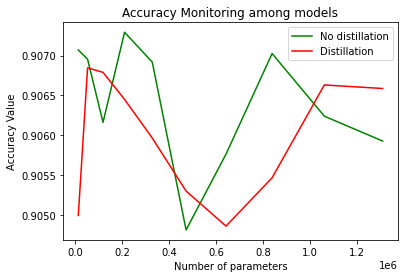

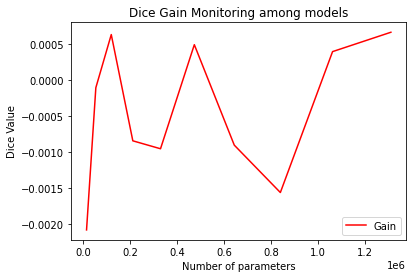

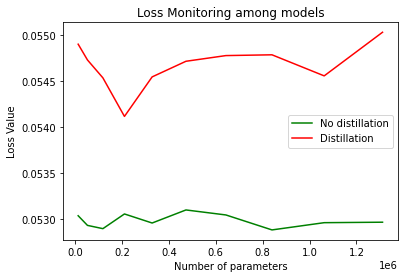

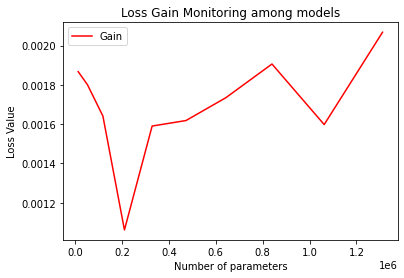

In [ ]:
nd_dice_average = np.mean(nd_dice, axis=0)
nd_loss_average = np.mean(nd_loss, axis=0)

d_dice_average = np.mean(d_dice, axis=0)
d_loss_average = np.mean(d_loss, axis=0)


# PLOT ACCURACY
print(nd_param)
# Plot accuracy in respect to the number of parameters
plt.figure(1)
plt.clf()
plt.plot(nd_param, nd_dice_average,
			'g-', label='No distillation')
plt.plot(d_param, d_dice_average,
			'r-', label='Distillation')
plt.xlabel("Number of parameters")
plt.ylabel("Accuracy Value")
plt.title("Accuracy Monitoring among models")
plt.legend()
plt.savefig(fig_path + "accuracy_param.png")
plt.show()



# Plot the gain in accuracy in respect to the number of parameters for the distilled models
plt.figure(1)
plt.clf()
plt.plot(d_param, d_dice_average-nd_dice_average,
			'r-', label='Gain')
plt.xlabel("Number of parameters")
plt.ylabel("Dice Value")
plt.title("Dice Gain Monitoring among models")
plt.legend()
plt.savefig(fig_path + "dice_gain_param.png")
plt.show()



# PLOT LOSS

# Plot loss in respect to the number of parameters
plt.figure(1)
plt.clf()
plt.plot(nd_param, nd_loss_average,
			'g-', label='No distillation')
plt.plot(d_param, d_loss_average,
			'r-', label='Distillation')
plt.xlabel("Number of parameters")
plt.ylabel("Loss Value")
plt.title("Loss Monitoring among models")
plt.legend()
plt.savefig(fig_path + "loss_param.png")
plt.show()


# Plot the gain in loss in respect to the number of parameters for the distilled models
plt.figure(1)
plt.clf()
plt.plot(d_param, np.array(d_loss_average)-np.array(nd_loss_average),
			'r-', label='Gain')
plt.xlabel("Number of parameters")
plt.ylabel("Loss Value")
plt.title("Loss Gain Monitoring among models")
plt.legend()
plt.savefig(fig_path + "loss_gain_param.png")
plt.show()

log_file = open(log_path+"raw_data"+session_name+".txt", "w")
log_file.write("Not distilled data\n")
log_file.write("number of param : " + str(nd_param) + "\n")
log_file.write("accuracy : " + str(nd_dice) + "\n")
log_file.write("loss : " + str(nd_loss) + "\n")


log_file.write("Distilled data\n")
log_file.write("number of param : " + str(d_param) + "\n")
log_file.write("accuracy : " + str(d_dice) + "\n")
log_file.write("loss : " + str(d_loss) + "\n")


log_file.close()


In [ ]:
print(nd_param)
print(nd_dice)
print(nd_loss)

print(d_param)
print(d_dice)
print(d_loss)

[]
[]
[]
[]
[]
[]


In [ ]:
"""global_step =  0
n_train = len(filtered_train_data)
print(n_train)

T = 1.0 # temperature for distillation loss
# Using a higher value for T produces a softer probability distribution over classes
alpha = 1.0
# trade-off between soft-target (st) cross-entropy and true-target (tt) cross-entropy;
# loss = alpha * st + (1 - alpha) * tt

print("Starting Training Loop...")


source_dice = []
intervalle = []

L_seg_list = []

loss_list = []
acc_list = []

L_s_list = []

compteur_plot = 0

for epoch in range(num_epochs):
	epoch_loss = 0
	epoch_acc = 0
	cpt_it = 0
	with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='img') as pbar:

		for i, data in enumerate(filtered_train_dataloader, 0):
			student_model.train()
			teacher_model.eval()

			cpt_it += 1

			X, y = data

			X = X.to(
				device=device, dtype=torch.float32)
			y = y.to(
				device=device, dtype=torch.long)

			# Pass Data Trought net before optimizing everything

			loss, acc = studentTrainStep(teacher_model, student_model, studentLoss, optimizer_global, X, y, T, alpha)
			

			L_global = loss

			###########################################################
			# Evaluation on the Training Set
			###########################################################

			student_model.eval()

			intervalle.append(compteur_plot)
			compteur_plot += 1

			global_step += 1
			epoch_loss += loss.item()
			epoch_acc += acc

			pbar.update(X.shape[0])
			pbar.set_postfix(
				**{'loss (batch)': epoch_loss/cpt_it, "accuracy (batch)": epoch_acc/cpt_it})
			# pbar.set_postfix(**{'dice target': dice_target})

			loss_list.append(loss.item())
			acc_list.append(acc)
# print("whole epoch target dice mean :", sum(dice_score_target)/cpt_it)
		if (epoch % batch_save_interval == 0):  # and epoch != 0 :

			loss_smooth = smooth(loss_list, 0.99)
			acc_smooth = smooth(acc_list, 0.99)

			torch.save(student_model.state_dict(), saving_folder +
					   "/newtork_weigths/net_epoch{:}_acc{:.3f}_loss{:.3f}.pth".format(epoch, epoch_acc/cpt_it, epoch_loss/cpt_it))

			plt.figure(1)
			plt.clf()
			plt.plot(intervalle, acc_smooth, 'r-', label='Global accuracy')
			plt.xlabel("iterations")
			plt.ylabel("Accuracy Value")
			plt.title("Accuracy Monitoring among training")
			plt.legend()
			plt.savefig(saving_folder+"/training_monitoring/acc_" +
						str(epoch)+"_epoch.png")
			plt.show()

			plt.figure(1)
			plt.clf()
			plt.plot(intervalle, loss_smooth, 'r-', label='Global loss')
			plt.xlabel("iterations")
			plt.ylabel("Loss Value")
			plt.title("Loss Monitoring among training")
			plt.legend()
			plt.savefig(saving_folder+"/training_monitoring/loss_" +
						str(epoch)+"_epoch.png")
			plt.show()"""


: 